In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint as pp
import gym

from lstd import LSTDQ, LSTDMu, LSPI
from simulator import Simulator
from policy import *
import sklearn.pipeline
import sklearn.preprocessing
from sklearn.kernel_approximation import RBFSampler
import seaborn as sns
from sklearn import manifold, datasets
from sklearn.utils import check_random_state

In [5]:
# hypyerparams
gamma= 0.75
s0 = [-0.5, -0.05]

In [6]:
env = gym.envs.make("MountainCar-v0")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [7]:
pp(env.observation_space.sample())
pp(env.action_space.sample())

array([-0.2121357 ,  0.03012651], dtype=float32)
1


## build basis functions
- linear (3d: pos, velo, action)
- RBFwith 400 components with varying gammas

In [8]:
def get_phi(scaler):
    # Used to converte a state to a featurizes represenation.
    # We use RBF kernels with different variances to cover different parts of the space
    phi = sklearn.pipeline.FeatureUnion([
            ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
            ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
            ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
            ("rbf4", RBFSampler(gamma=0.5, n_components=100))
            ])
    phi.fit(scaler.transform(xs))
    
    def f(s, a):
        sa = np.hstack((s, a))
        if len(sa.shape) == 1:
            sa = np.expand_dims(sa, axis=0)
        x = scaler.transform(sa)
        return phi.transform(x).T
    
    return f

def get_psi(scaler):
    # Used to converte a state to a featurizes represenation.
    # We use RBF kernels with different variances to cover different parts of the space
    psi = sklearn.pipeline.FeatureUnion([
            ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
            ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
            ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
            ("rbf4", RBFSampler(gamma=0.5, n_components=100))
            ])
    psi.fit(scaler.transform(xs))
    
    def f(s, a):
        sa = np.hstack((s, a))
        if len(sa.shape) == 1:
            sa = np.expand_dims(sa, axis=0)
        x = scaler.transform(sa)
        return psi.transform(x).T
    
    return f


# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this
states = np.array([env.observation_space.sample() for x in range(10000)])
actions = np.array([env.action_space.sample() for x in range(10000)]).reshape(10000, 1)
xs = np.hstack((states, actions))

print(xs.shape)
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(xs)

def simple_phi(s, a):
    # identity
    return np.expand_dims(np.hstack((s, a)), axis=1)

phi_rbf = get_phi(scaler)
psi_rbf = phi_rbf
phi_linear = simple_phi
psi_linear = phi_linear

(10000, 3)


## make behavior policies

In [9]:
# pi_expert


# pi_explore
pi1 = RandomPolicy2(choices=[0]) # left
pi2 = RandomPolicy2(choices=[2]) # right
pi3 = RandomPolicy2(choices=[0, 2]) # left, right

class ManualPolicy():
    def choose_action(self, s):
        pos, v = s
        return 0 if v <=0 else 2
pi4 = ManualPolicy()
# pi_evaluate
pi5 = RandomPolicy2(choices=[0, 1, 2]) # left, right




## Train DQN on Mountaincar

In [24]:
import baselines
from baselines import deepq

In [38]:
# Enabling layer_norm here is import for parameter space noise!
model = deepq.models.mlp([64], layer_norm=True)
act = deepq.learn(
    env,
    q_func=model,
    lr=1e-3,
    max_timesteps=100000,
    buffer_size=50000,
    exploration_fraction=0.1,
    exploration_final_eps=0.1,
    print_freq=10,
    param_noise=True
)
print("Saving model to mountaincar_model.pkl")
act.save("mountaincar_model.pkl")

/usr/local/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib64/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


--------------------------------------
| % time spent exploring  | 83       |
| episodes                | 10       |
| mean 100 episode reward | -200     |
| steps                   | 1799     |
--------------------------------------
--------------------------------------
| % time spent exploring  | 65       |
| episodes                | 20       |
| mean 100 episode reward | -200     |
| steps                   | 3799     |
--------------------------------------
--------------------------------------
| % time spent exploring  | 47       |
| episodes                | 30       |
| mean 100 episode reward | -200     |
| steps                   | 5799     |
--------------------------------------
--------------------------------------
| % time spent exploring  | 29       |
| episodes                | 40       |
| mean 100 episode reward | -200     |
| steps                   | 7799     |
--------------------------------------
--------------------------------------
| % time spent exploring 

--------------------------------------
| % time spent exploring  | 9        |
| episodes                | 350      |
| mean 100 episode reward | -171     |
| steps                   | 64327    |
--------------------------------------
--------------------------------------
| % time spent exploring  | 9        |
| episodes                | 360      |
| mean 100 episode reward | -170     |
| steps                   | 66013    |
--------------------------------------
--------------------------------------
| % time spent exploring  | 9        |
| episodes                | 370      |
| mean 100 episode reward | -166     |
| steps                   | 67522    |
--------------------------------------
--------------------------------------
| % time spent exploring  | 9        |
| episodes                | 380      |
| mean 100 episode reward | -164     |
| steps                   | 69076    |
--------------------------------------
Saving model due to mean reward increase: -172.1 -> -164.2
-----

In [40]:
# Load from pickle
#act = deepq.load("mountaincar_model.pkl")

In [71]:
# Wrapper so that choose_action is exposed
class Dqn_wrapper(object):
    def __init__(self, act):
        self.act = act
    
    def choose_action(self, s):
        return self.act(s[None], None, None, None)[0]
    
# Instantiate
pi_dqn = Dqn_wrapper(act)

## generate trajectories under behavior policy (=D)

- behavior policy: optimal (expert) + suboptimal
- right now use only quasi optimal + suboptimal

In [73]:
state_dim = env.observation_space.shape[0]
# discrete action
action_dim = 1
n_action = env.action_space.n
sim = Simulator(env, state_dim=state_dim, action_dim=action_dim)
trajs1 = sim.simulate(pi1, n_trial=1, n_episode=50)
trajs2 = sim.simulate(pi2, n_trial=1, n_episode=50)
trajs3 = sim.simulate(pi3, n_trial=1, n_episode=50)
trajs4 = sim.simulate(pi4, n_trial=1, n_episode=50)
trajs_dqn = sim.simulate(pi_dqn, n_trial=1, n_episode=50)

In [74]:
trajs = trajs1 + trajs2 + trajs3 + trajs4

In [77]:
def draw_traj(traj_, title=None):
    states = []
    actions = []
    rewards = []
    for t in traj_:
        for (s, a, r, s_next, done) in t:
            states.append(s)
            actions.append(a)
            rewards.append(r)

    print(np.sum(np.array(rewards) < 0))
    states = np.array(states)
    sns.set(style='white', palette='Blues')
    ax = plt.gca()

    sc = ax.scatter(states[:,0], states[:,1], c=rewards, alpha=0.3)
    ax.axis([-1.2,0.6,-0.07,0.07])
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    if title:
        ax.set_title(title)
    #plt.colorbar(sc)
    plt.show()

36622


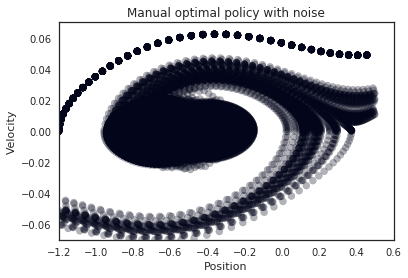

In [79]:
draw_traj(trajs, 'Manual optimal policy with noise')

10000


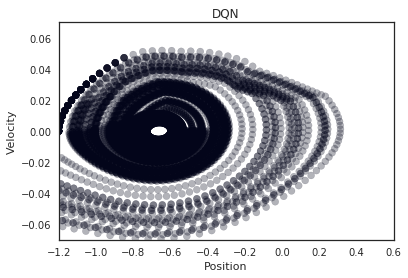

In [80]:
draw_traj(trajs_dqn, 'DQN')

## trajectories under evaluation policy

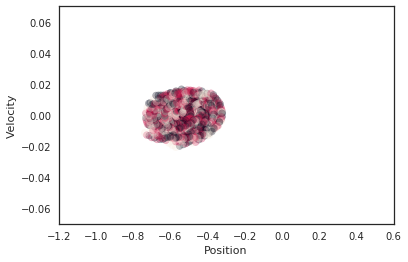

In [14]:
trajs5 = sim.simulate(pi5, n_trial=1, n_episode=10)
states = []
actions = []
for t in trajs5:
    for (s, a, r, s_next, done) in t:
        states.append(s)
        actions.append(a)

states = np.array(states)
sns.set(style='white', palette='Blues')
ax = plt.gca()
sc = ax.scatter(states[:,0], states[:,1], c=actions, alpha=0.3)
ax.axis([-1.2,0.6,-0.07,0.07])
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
#plt.colorbar(sc)
plt.show()

## Monte Carlo Mu estimation

In [15]:
import itertools
def estimate_mu_mc(env, pi, phi, gamma, n_episode):
    mus = []
    ss_init = []
    for epi_i in range(n_episode):
        
        # this is not fixed
        s = env.reset()
        ss_init.append(s)
        mu = 0.0
        for t in itertools.count():
            a = pi.choose_action(s)
            s_next, r, done, _ = env.step(a)
            # todo figure out whether it's phi(s,a) or phi(s)
            mu += gamma ** t * phi(s, a)
            s = s_next
            if done:
                break
        mus.append(mu)
    return mus, ss_init

## MC with linear bassis

In [16]:
mus_mc_linear, ss_init_linear = estimate_mu_mc(env, pi5, phi_linear, gamma, 1000)
mus_mc_linear = np.array(mus_mc_linear).squeeze()
np.mean(mus_mc_linear, axis=0)

array([ -2.02259482e+00,  -1.43604276e-03,   4.05152782e+00])

## MC with RBF bassis

In [17]:
mus_mc_rbf, ss_init_rbf = estimate_mu_mc(env, pi5, phi_rbf, gamma, 1000)
mus_mc_rbf = np.array(mus_mc_rbf).squeeze()
np.mean(mus_mc_rbf, axis=0)

array([ -8.65548215e-02,   4.32590146e-02,   6.85823415e-03,
        -3.44001750e-01,  -1.30067806e-01,   3.60052572e-01,
        -1.70257848e-01,   4.15824147e-01,  -1.64354907e-01,
        -4.46387547e-02,   1.28194636e-02,  -2.95392152e-02,
         8.35531843e-02,  -1.17072944e-01,   3.89439695e-01,
         8.45404025e-03,   1.54292681e-01,  -2.34770773e-01,
         7.20955661e-02,  -1.15083649e-01,   4.73733926e-01,
         9.63765721e-02,  -8.12712685e-02,   2.36023102e-01,
         1.34628037e-02,   2.07502067e-01,   1.94163297e-02,
        -4.86985886e-01,  -2.05307979e-02,   5.36380243e-01,
         2.54677635e-01,  -7.72680588e-02,  -1.72896727e-02,
        -1.96802003e-01,   4.18495367e-01,  -4.80318537e-01,
        -6.82949420e-02,  -4.70822680e-02,  -3.43391046e-02,
        -3.25804504e-01,   4.25234596e-02,   1.01668543e-02,
        -3.84780791e-02,  -4.66528207e-02,   1.27702759e-01,
        -2.17501088e-02,  -8.11613688e-02,  -4.22556157e-01,
        -1.88764330e-01,

## Visualize Monte Carlo $\mu$ of evaluation policy

- through direct simulation

In [18]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
trans_data = tsne.fit_transform(mus_mc_rbf).T

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
plt.suptitle('Monte Carlo Estimates')

ax1.scatter(mus_mc_linear[:, 0], mus_mc_linear[:, 1])
ax1.set_ylim(-0.02, 0.02)
ax1.set_xlabel('Position')
ax1.set_ylabel('Velocity')

# c= ..
ss = ax2.scatter(trans_data[0], trans_data[1], ;
ax2.set_title("t-SNE of mu_expert_stochastic")
ax2.axis('tight')
#fig.colorbar(ss, ax=ax2)
plt.show()
                 
# u_hat= 1/n sum_{i=1}^n (u_i)
# E[u_hat] = u
                 
                 

SyntaxError: invalid syntax (<ipython-input-19-550cc3fa72c9>, line 10)

## LSTD-mu estimation of evaluation policy
- with linear basis
- with rbf basis

In [ ]:
# depends on basis function
p_linear = 3
q_linear = 3
p_rbf = 400
q_rbf = 400
eps = 0.001
lm_linear = LSTDMu(p=p_linear, q=q_linear, phi=phi_linear, psi=psi_linear, gamma=gamma, eps=eps)
lm_rbf = LSTDMu(p=p_rbf, q=q_rbf, phi=phi_rbf, psi=psi_rbf, gamma=gamma, eps=eps)
lm_linear.fit(D=trajs, pi=pi5)
lm_rbf.fit(D=trajs, pi=pi5)

In [ ]:
#pp(np.mean(mus, axis=0))
mus_lstd_linear = []
mus_lstd_rbf = []

for s0 in ss_init:
    # linear
    mu = lm_linear.predict(s0, pi5.choose_action(s0))
    mus_lstd_linear.append(mu)
    # rbf
    mu_rbf = lm_rbf.predict(s0, pi5.choose_action(s0))
    mus_lstd_rbf.append(mu)

mus_lstd_linear = np.array(mus_lstd_linear).squeeze()
mus_lstd_rbf = np.array(mus_lstd_rbf).squeeze()


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
plt.suptitle('Distribution of mu expert')

ax1.scatter(mus_lstd_linear[:, 0], mus_lstd_linear[:, 1])
#ax1.set_ylim(-0.02, 0.02)
ax1.set_xlabel('Position')
ax1.set_ylabel('Velocity')

tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
trans_data = tsne.fit_transform(mus_lstd_rbf).T

ss = ax2.scatter(trans_data[0], trans_data[1], cmap='Reds')
ax2.set_title("t-SNE of mu_expert_stochastic")
ax2.axis('tight')
#fig.colorbar(ss, ax=[ax1, ax2])
plt.show()

## todo
- get pi expert using LSPI (or DDQN)
- run MMP/AL with LSTD-mu vs. MC-mu

## LSTD-mu
- is this a feature or a bug? (maybe this is just MC variance)
- expert mountain car

## ideas
- directed policy learning with IRL? 

## story
- mlhc: learning accurate reward functions
- ccm: interpretability & decision making

## not markovian?
- use lstm (r_t) + m_t -> phi(r_t, m_t) -> enough data?
- considering history (add temporal component - markovian)
- a strong baseline is to use supervised learning (imitation leanring)

## interpretability
- give pca basis if it makes sense 
- give final weights if it makes sense
- give a trajectory: sample a IRL trajectory (s, a, r, s') see if it makes sense
- check with li-wei


## outline
- raw observations
- discrete-state MDP
    - did not work as well because blah blah
    - bad transition
    - limited state representation
- continuous-state MDP with apprenticeship learning
    - with apprenticeship learning
    
- continuous-state MDP with maximum margin planning
    - shortcoming: no direct control for taking rare actions/rare states
    - suboptimality of expert: introduce slack term
- results
    - mu/v convergence
    - pi matching (metric/trajectory)
    - interpretation of weights, trajectories (how?)

## methods
- mu estimates
- max margin
- ddqn & experience replay


## apply apprenticeship learning

In [ ]:
## value margin

## apply maximum margin planning